In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import random 
import os
import pymc as pm
import datetime
import pickle

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# CONFIG

**Set sample to False if you want to run algos on entire dataset**

In [ ]:
CONFIG = {
    'sample': True,
    'sample_months': 1, # how many months to sample (for development)
    'top_n_clusters': 1, # how many clusters to train
    'random_state': 123,
    'target_col': 'delta',
    'n_jobs': 4,  # gridsearch parallelization, might need to adjust based on your system
    'ts_splits': 5, # TimeSeriesSplit number of splits
    'ts_gap': 48,  # 2-day gap
    'visualize_clusters': False
}

FEATURE_COLS = {
    'categorical': ['isHoliday', 'has_kiosk', 'weather_cluster', 'workhours', 'commute', 'free', 'night'],
    'drop': ['sum', 'weather_code', 'timestamp', 'station_name', 'arrivals', 'departures', 'num_docks_available', 'num_ebikes_available', 'capacity', 'cluster', 'sunset', 'sunrise', 'year', 'day', 'hour_extract', 'precipitation'],
    'time': ['weekday', 'month', 'hour']
}

# DATA LOADING

In [ ]:
df = pd.read_parquet("/data/final/df.parquet")

In [ ]:
FEATURE_COLS["drop"] = FEATURE_COLS["drop"] + [col for col in df.columns if (col.startswith("var") or col.startswith("avg"))]

In [ ]:
print(df.shape)

(6464880, 94)


In [ ]:
# REDUCE DATASET SIZE FOR DEVELOPMENT
if CONFIG['sample']:
    months = df['timestamp'].dt.month.unique()
    random_month = random.sample(list(months), CONFIG['sample_months'])
    df = df[df['timestamp'].dt.month.isin(random_month)]
    print(f'Sampled {CONFIG["sample_months"]} month(s): {random_month}')

Sampled 1 month(s): [np.int32(8)]


In [ ]:
df.head()

,station_name,hour,departures,arrivals,hour_extract,temperature_2m,weather_code,rain,precipitation,snowfall,...,var_sum_station_nonnight,avg_sum_station_holiday,var_sum_station_holiday,avg_sum_station_commute,var_sum_station_commute,avg_sum_station_free,var_sum_station_free,avg_sum_station_unfriendly_weather,var_sum_station_unfriendly_weather,cluster
5088,10th & E St NW,0,0.0,0.0,0,20.835999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5089,10th & E St NW,1,0.0,0.0,1,20.785999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5090,10th & E St NW,2,0.0,0.0,2,20.035999,0.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5091,10th & E St NW,3,0.0,0.0,3,19.236000,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5
5092,10th & E St NW,4,0.0,0.0,4,18.935999,1.0,0.0,0.0,0.0,...,15.351129,2.660256,14.983882,3.992523,16.957668,2.487069,12.603498,2.55168,11.25476,5


In [ ]:
# All remaining columns are considered numerical
FEATURE_COLS['numerical'] = [col for col in df.columns if col not in ([CONFIG['target_col']] + FEATURE_COLS['categorical'] + FEATURE_COLS['drop'] + FEATURE_COLS['time'])]

In [ ]:
# Sanity check for features
print("Categorical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['categorical']))
print("Drop:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['drop']))
print("Time:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['time']))
print("Numerical:\n" + '\n'.join(f"  - {feature_col}" for feature_col in FEATURE_COLS['numerical']))

Categorical:
  - isHoliday
  - has_kiosk
  - weather_cluster
  - workhours
  - commute
  - free
  - night
Drop:
  - sum
  - weather_code
  - timestamp
  - station_name
  - arrivals
  - departures
  - num_docks_available
  - num_ebikes_available
  - capacity
  - cluster
  - sunset
  - sunrise
  - year
  - day
  - hour_extract
  - precipitation
  - var_delta_station_total
  - avg_delta_station_total
  - avg_arrivals_station_total
  - avg_departures_station_total
  - var_arrivals_station_total
  - var_departures_station_total
  - avg_delta_station_night
  - var_delta_station_night
  - avg_arrivals_station_night
  - var_arrivals_station_night
  - avg_departures_station_night
  - var_departures_station_night
  - avg_delta_station_nonnight
  - var_delta_station_nonnight
  - avg_arrivals_station_nonnight
  - var_arrivals_station_nonnight
  - avg_departures_station_nonnight
  - var_departures_station_nonnight
  - avg_delta_station_holiday
  - var_delta_station_holiday
  - avg_arrivals_station_

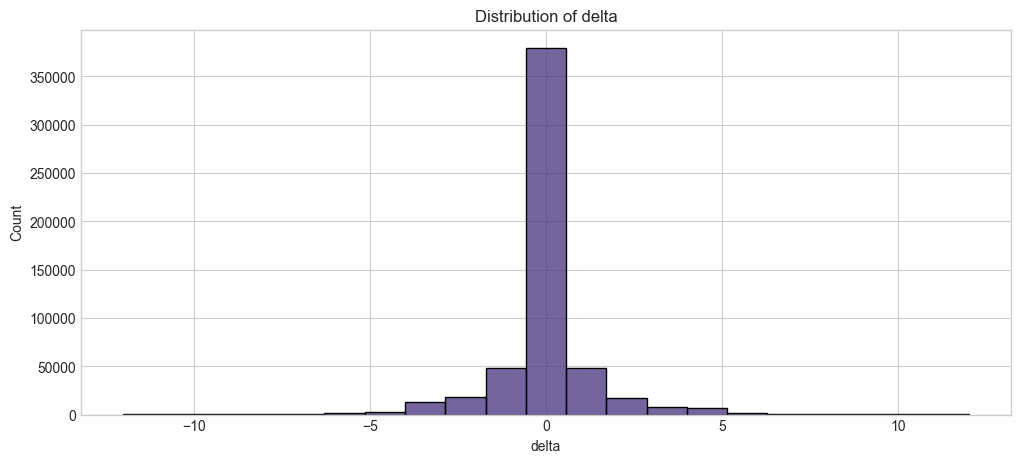

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(12, 5))
sns.histplot(df[CONFIG['target_col']], binrange=(-12, 12))
plt.title(f'Distribution of {CONFIG["target_col"]}')
plt.show()

## Data preparation

In [ ]:
# Prepare data for modeling
def prepare_data(df, target_col, categorical_cols, numerical_cols, time_cols, drop_cols):
    # Drop rows with NaN
    df_clean = df.dropna()
    # Drop rows with zero target
    print(f"Dropped {len(df) - len(df_clean)} rows with NaN values.")
    
    # Keep datetime for reference
    datetime_col = df_clean['datetime'] if 'datetime' in df_clean.columns else None
    
    # Drop columns defined above
    df_clean = df_clean.drop(columns=drop_cols, errors='ignore')

    # Split features and target
    X = df_clean[categorical_cols + numerical_cols + time_cols]
    y = df_clean[target_col]
    
    return X, y, datetime_col

# Test-apply data preparation
X, y, datetime_col = prepare_data(df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
X.head()

Dropped 0 rows with NaN values.
Features shape: (549072, 21)
Target shape: (549072,)


,isHoliday,has_kiosk,weather_cluster,workhours,commute,free,night,temperature_2m,rain,snowfall,...,wind_gusts_10m,wind_speed_10m,num_bikes_available,latitude,longitude,dayofweek,dayofyear,weekday,month,hour
5088,False,YES,clear_and_cloudy,False,False,False,True,20.835999,0.0,0.0,...,13.320000,8.534353,12,38.895914,-77.026064,1,213,1,8,0
5089,False,YES,clear_and_cloudy,False,False,False,True,20.785999,0.0,0.0,...,21.240000,11.367109,12,38.895914,-77.026064,1,213,1,8,1
5090,False,YES,clear_and_cloudy,False,False,False,True,20.035999,0.0,0.0,...,19.799999,9.255571,12,38.895914,-77.026064,1,213,1,8,2
5091,False,YES,clear_and_cloudy,False,False,False,True,19.236000,0.0,0.0,...,16.919998,9.511088,12,38.895914,-77.026064,1,213,1,8,3
5092,False,YES,clear_and_cloudy,False,False,False,True,18.935999,0.0,0.0,...,17.639999,9.885262,12,38.895914,-77.026064,1,213,1,8,4


## Modeling
### Pipelines

In [ ]:

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

# Function to create model pipelines for each cluster
def create_model_pipelines(categorical_cols, numerical_cols, time_cols):
    
    preprocessor_plain = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ], remainder='passthrough')
    
    preprocessor_onehot = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), time_cols),
    ], remainder='passthrough')
    
    # Prepared but currently not in use
    preprocessor_sincos = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('sin_month', sin_transformer(12), ['month']),
        ('sin_hour', sin_transformer(24), ['hour']),
        ('sin_weekday', sin_transformer(7), ['weekday']),
        ('cos_month', cos_transformer(12), ['month']),
        ('cos_hour', cos_transformer(24), ['hour']),
        ('cos_weekday', cos_transformer(7), ['weekday'])
    ], remainder='passthrough')
    
    # Create pipelines
    pipelines = {
        'linear': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', LinearRegression())
        ]),
        
        'lasso': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Lasso(random_state=CONFIG['random_state']))
        ]),
        
        'ridge': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', Ridge(random_state=CONFIG['random_state']))
        ]),
        
        'decision_tree': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', DecisionTreeRegressor(random_state=CONFIG['random_state']))
        ]),
        'random_forest': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', RandomForestRegressor(random_state=CONFIG['random_state']))
        ]),
        'xgboost': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=CONFIG['random_state']))
        ]),
        'gbm': Pipeline([
            ('preprocessing', 'passthrough'),
            ('regressor', GradientBoostingRegressor(random_state=CONFIG['random_state']))
        ])
    }
    
    # Store preprocessor strategies
    preprocessing_strategies = {
        'plain': preprocessor_plain,
        'onehot': preprocessor_onehot,
        'sincos': preprocessor_sincos
    }
    
    preprocessor_plain.strategy_name = 'Plain'
    preprocessor_onehot.strategy_name = 'OneHot'  
    preprocessor_sincos.strategy_name = 'SinCos'
    
    return pipelines, preprocessing_strategies

# Function to get parameter grids
def get_param_grids(preprocessing_strategies):
    return {
        'linear': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ]
            },
        
        'lasso': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20),
            'regressor__max_iter': [1000, 2000]
        },
        
        'ridge': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__alpha': np.logspace(-4,4,20)
        },
        
        'decision_tree': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'random_forest': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [10, 20],
            'regressor__min_samples_split': [2, 5, 10, 15, 20]
        },
        
        'xgboost': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        },
        
        'gbm': {
            'preprocessing': [
                preprocessing_strategies['plain'],
                preprocessing_strategies['onehot'],
                preprocessing_strategies['sincos']
            ],
            'regressor__n_estimators': [50, 100],
            'regressor__max_depth': [3, 6],
            'regressor__learning_rate': [0.01, 0.1]
        }
    }

In [ ]:
# Function to plot feature importance
def plot_feature_importance(model_name, model, X):
    # Extract the regressor from pipeline
    regressor = None
    for step_name, step in model.named_steps.items():
        if hasattr(step, 'feature_importances_'):
            regressor = step
            break
    
    if regressor is None:
        print(f"Model {model_name} doesn't support feature importance.")
        return
    
    # Get feature names after preprocessing
    try:
        # Try to get preprocessed feature names
        if 'preprocessing' in model.named_steps and hasattr(model['preprocessing'], 'get_feature_names_out'):
            feature_names = model['preprocessing'].get_feature_names_out()
        else:
            # Fallback to original feature names or indices
            feature_names = X.columns if hasattr(X, 'columns') else [f"feature_{i}" for i in range(X.shape[1])]
        
        # Ensure the lengths match
        if len(feature_names) != len(regressor.feature_importances_):
            print(f"Warning: Feature names length ({len(feature_names)}) doesn't match importances length ({len(regressor.feature_importances_)})")
            # Use indices as fallback
            feature_names = [f"feature_{i}" for i in range(len(regressor.feature_importances_))]
            
        # Extract feature importances
        importance = regressor.feature_importances_
        
        # Create DataFrame for better visualization
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        # Plot
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
        
        print(f"Feature importance report for {model_name}:")
        print(feature_imp)
        
        return feature_imp
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        return None

In [ ]:
# Function to make and visualize predictions
def visualize_predictions(model_name, model, X, y, datetime_col):
    # Make predictions
    y_pred = model.predict(X)
    
    # Create a DataFrame for plotting
    pred_df = pd.DataFrame({
        'datetime': datetime_col,
        'actual': y,
        'predicted': y_pred
    })
    
    # Calculate metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    # Plot actual vs predicted
    plt.figure(figsize=(15, 6))
    plt.plot(pred_df['datetime'], pred_df['actual'], label='Actual', alpha=0.7)
    plt.plot(pred_df['datetime'], pred_df['predicted'], label='Predicted', alpha=0.7)
    plt.title(f'{model_name} - Actual vs Predicted (MSE: {mse:.2f}, R²: {r2:.2f})')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot residuals
    pred_df['residual'] = pred_df['actual'] - pred_df['predicted']
    
    plt.figure(figsize=(15, 6))
    plt.scatter(pred_df['predicted'], pred_df['residual'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name} - Residuals Plot')
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.tight_layout()
    plt.show()
    
    return pred_df

### Train

In [ ]:
def storeModelMetricsOnDisc(name, results):
    FILE = "/content/drive/My Drive/ML_Bikes_Modelling/model_train_checkpointing.txt"
    best_params = ' '.join(str(results['best_params']).replace('\n', '').split())
    time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())
    with open(FILE, 'a') as file:
        file.write(f"{time_string}--{name},{best_params},{results['best_score']},{results['rmse']},{results['mean_train_score']}\n")

In [ ]:
# Function to train and evaluate a single model
def train_evaluate_model(name, pipeline, param_grid, X, y, n_splits=CONFIG['ts_splits']):
    print(f"\nTraining {name} model...")
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        gap=CONFIG['ts_gap'])
    
    # GridSearch with time series split
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        cv=tscv, 
        scoring='neg_mean_squared_error',
        n_jobs=CONFIG['n_jobs'],
        verbose=1,
        return_train_score=True,
    )
    
    grid_search.fit(X, y)
    
    best_params = grid_search.best_params_
    if 'preprocessing' in best_params.keys():
        if hasattr(best_params['preprocessing'], 'strategy_name'):
            preproc_name = best_params['preprocessing'].strategy_name
    else:
        preproc_name = 'Unknown'
    
    # Store results
    best_model = grid_search.best_estimator_
    mean_train_score = -grid_search.cv_results_['mean_train_score']
    result = {
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'rmse': np.sqrt(-grid_search.best_score_),
        'mean_train_score': np.mean(mean_train_score),
    }
    
    print(f"  Best parameters: {grid_search.best_params_}")
    print(f"  Preprocessing strategy: {preproc_name}")
    print(f"  MSE: {-grid_search.best_score_:.4f}")
    print(f"  RMSE: {np.sqrt(-grid_search.best_score_):.4f}")
    print(f"  Mean Train Score: {np.mean(mean_train_score)}")
    storeModelMetricsOnDisc(name, result)

    return best_model, result

In [ ]:
def prepare_cluster_data(cluster_id, df_processed):

    cluster_df = df_processed[df_processed['cluster'] == cluster_id].copy()
    return prepare_data(cluster_df, CONFIG['target_col'], FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'], FEATURE_COLS['drop'])

def train_cluster_models(X, y, models_to_train):

    best_models = {}
    results = {}
    
    pipelines, preprocessing_strategies = create_model_pipelines(FEATURE_COLS['categorical'], FEATURE_COLS['numerical'], FEATURE_COLS['time'])
    param_grids = get_param_grids(preprocessing_strategies)
    
    for model_name in models_to_train:
        if model_name in pipelines:
            best_models[model_name], results[model_name] = train_evaluate_model(
                model_name, pipelines[model_name], param_grids[model_name], X, y
            )
    
    return best_models, results

def create_comparison_df(results_dict):

    comparison = pd.DataFrame({
        'Model': list(results_dict.keys()),
        'RMSE': [results_dict[m]['rmse'] for m in results_dict.keys()]
    }).sort_values('RMSE')
    
    return comparison

In [ ]:
# LEGACY
# # Store cluster results
# all_cluster_models = {}
# all_cluster_results = {}
# all_cluster_comparisons = {}

# # Function to train models for a single cluster
# def train_models_for_cluster(cluster_id, df_processed, models_to_train):
#     # Print heading
#     print(f"\n{'='*50}")
#     print(f"Training models for Cluster {cluster_id}")
#     print(f"{'='*50}")
    
#     # Get data for this cluster
#     X_cluster, y_cluster, datetime_col_cluster = prepare_cluster_data(cluster_id, df_processed)
#     print(f"Cluster size: {len(X_cluster)} records")
    
#     # Train models
#     best_models_cluster, results_cluster = train_cluster_models(X_cluster, y_cluster, models_to_train)
    
#     # Compare models for this cluster
#     comparison_cluster = pd.DataFrame({
#         'Model': list(results_cluster.keys()),
#         'RMSE': [results_cluster[m]['rmse'] for m in results_cluster.keys()]
#     }).sort_values('RMSE')
    
#     print(f"\nModel Comparison for Cluster {cluster_id}:")
#     print(comparison_cluster)
    
#     # Plot comparison
#     plt.figure(figsize=(12, 6))
#     sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
#     plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
#     plt.tight_layout()
#     plt.show()
    
#     # Show feature importance for tree-based models
#     for model_name in ['xgboost', 'random_forest', 'decision_tree']:
#         if model_name in best_models_cluster:
#             print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
#             feature_importance = plot_feature_importance(model_name, best_models_cluster[model_name], X_cluster)
#             print(f"Feature importance report for {model_name}:")
#             print(feature_importance)


#     # "feature importance" for regression methods -> doesn't work yet!
#     for model_name in ['linear', 'lasso', 'ridge']:
#         print(f"\nModel coefficients for {model_name} in Cluster {cluster_id}:")
#         print("coefficients")
#         print(best_models_cluster[model_name].coef_)
    
#     # Visualize best model predictions
#     best_model_name = comparison_cluster['Model'].iloc[0]
#     print(f"Best model for Cluster {cluster_id}: {best_model_name} with RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
#     if best_model_name in best_models_cluster:
#         visualize_predictions(
#             f"{best_model_name} (Cluster {cluster_id})", 
#             best_models_cluster[best_model_name], 
#             X_cluster, y_cluster, datetime_col_cluster
#         )
    
#     return best_models_cluster, results_cluster, comparison_cluster

Found 10 clusters: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Processing Cluster 0
Dropped 0 rows with NaN values.
Cluster size: 41760 records

Training decision_tree model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
  Best parameters: {'preprocessing': ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'rain', 'snowfall',
                                  'cloud_cover', 'wind_gusts_10m',
                                  'wind_speed_10m', 'num_bikes_available',
                                  'latitude', 'longitude', 'dayofweek',
                                  'dayofyear']),
                                ('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['isHoliday', 'has_kiosk', 'weather_cluster',
                                  'workh

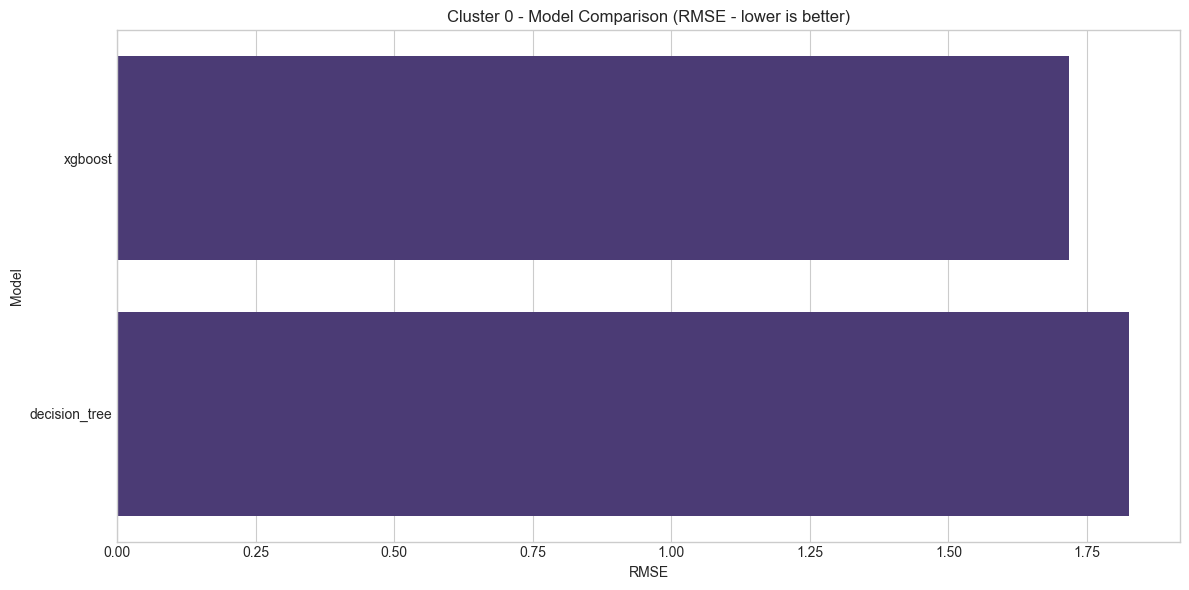


Feature Importance for xgboost in Cluster 0:


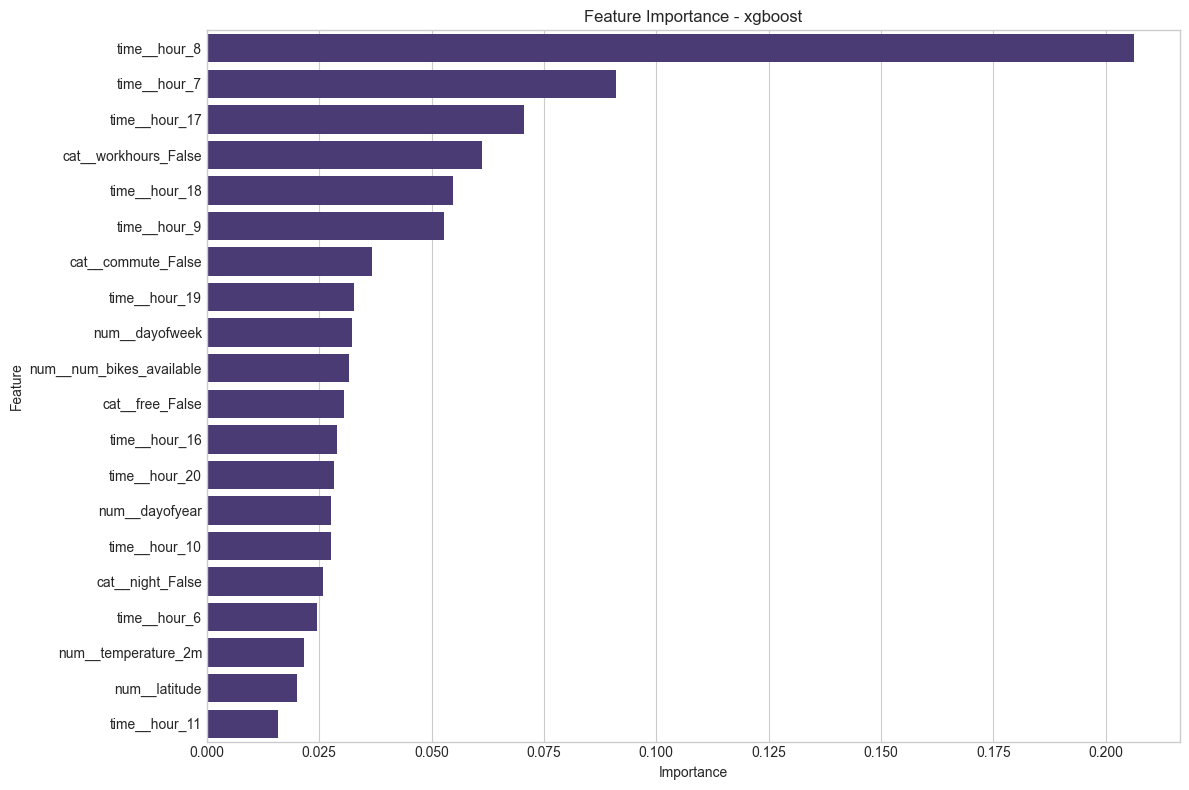

Feature importance report for xgboost:
                                      Feature  Importance
41                               time__hour_8    0.206262
40                               time__hour_7    0.091063
50                              time__hour_17    0.070611
17                       cat__workhours_False    0.061163
51                              time__hour_18    0.054840
42                               time__hour_9    0.052849
19                         cat__commute_False    0.036843
52                              time__hour_19    0.032625
9                              num__dayofweek    0.032359
6                    num__num_bikes_available    0.031718
21                            cat__free_False    0.030566
49                              time__hour_16    0.029043
53                              time__hour_20    0.028209
10                             num__dayofyear    0.027625
43                              time__hour_10    0.027534
23                           cat_

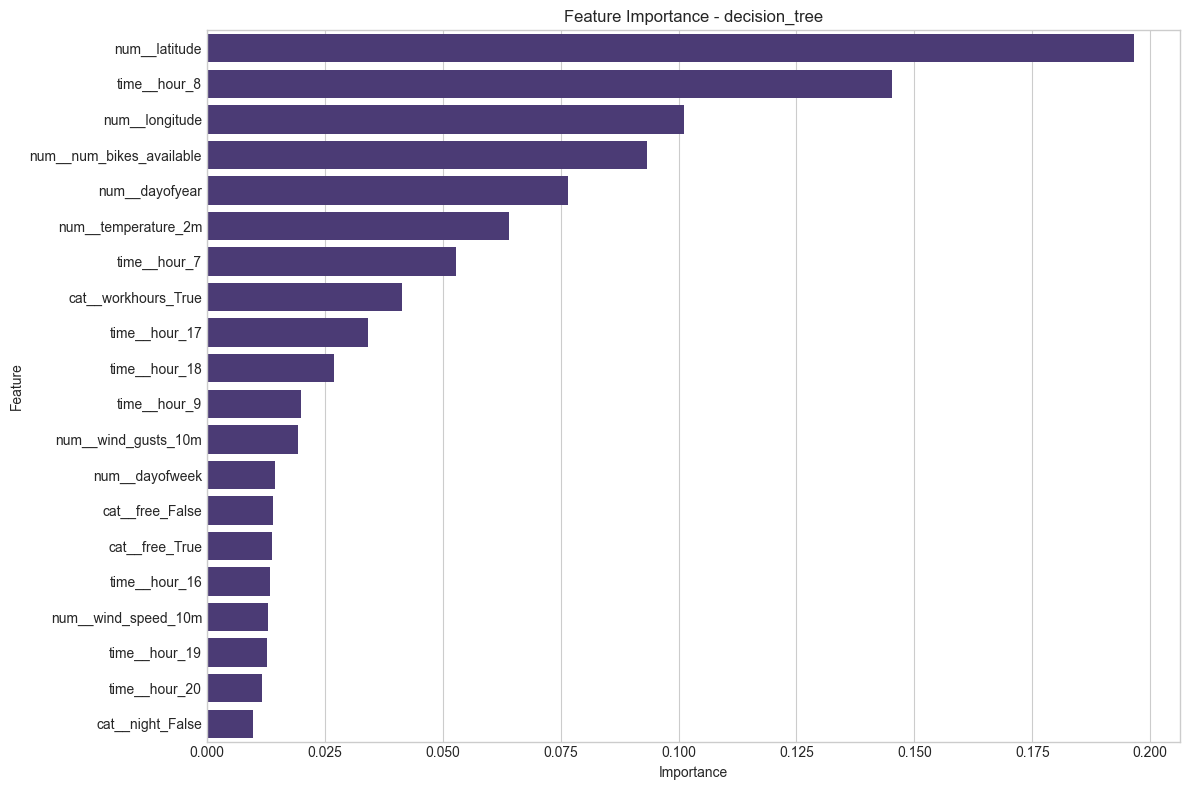

Feature importance report for decision_tree:
                                      Feature  Importance
7                               num__latitude    0.196487
41                               time__hour_8    0.145231
8                              num__longitude    0.101233
6                    num__num_bikes_available    0.093235
10                             num__dayofyear    0.076599
0                         num__temperature_2m    0.063948
40                               time__hour_7    0.052792
18                        cat__workhours_True    0.041261
50                              time__hour_17    0.034134
51                              time__hour_18    0.026961
42                               time__hour_9    0.020034
4                         num__wind_gusts_10m    0.019235
9                              num__dayofweek    0.014354
21                            cat__free_False    0.013960
22                             cat__free_True    0.013819
49                         

In [ ]:
#models_to_train = ['linear', 'lasso', 'ridge', 'decision_tree', 'xgboost', 'random_forest']
#models_to_train = ["linear", "lasso", "ridge"]
models_to_train = ['linear', 'lasso','decision_tree','xgboost']
unique_clusters = sorted(df['cluster'].unique().tolist())
print(f"Found {len(unique_clusters)} clusters: {unique_clusters}")

# # Store cluster results
all_cluster_models = {}
all_cluster_results = {}
all_cluster_comparisons = {}

# Train models for each cluster
for i, cluster_id in enumerate(unique_clusters):
    print(f"\n{'='*50}\nProcessing Cluster {cluster_id}\n{'='*50}")
    
    # Get data for this cluster
    X_cluster, y_cluster, datetime_col = prepare_cluster_data(cluster_id, df)
    print(f"Cluster size: {len(X_cluster)} records")
    
    # Train models
    models, results = train_cluster_models(X_cluster, y_cluster, models_to_train)
    time_string = '{date:%Y-%m-%d_%H:%M:%S}'.format(date=datetime.datetime.now())
    with open(f"/content/drive/My Drive/ML_Bikes_Modelling/{cluster_id}-best_models-{time_string}.pkl", 'wb') as outp:
        pickle.dump([models, results], outp, pickle.HIGHEST_PROTOCOL)

    # Store results
    all_cluster_models[cluster_id] = models
    all_cluster_results[cluster_id] = results
    all_cluster_comparisons[cluster_id] = create_comparison_df(results)
            
    print(f"\nModel Comparison for Cluster {cluster_id}:")
    print(comparison_cluster)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='RMSE', y='Model', data=comparison_cluster)
    plt.title(f'Cluster {cluster_id} - Model Comparison (RMSE - lower is better)')
    plt.tight_layout()
    plt.show()
    
    # Show feature importance for tree-based models
    # for model_name in ['xgboost', 'random_forest', 'decision_tree']:
    # if model_name in models:
    #     print(f"\nFeature Importance for {model_name} in Cluster {cluster_id}:")
    #     feature_importance = plot_feature_importance(model_name, models[model_name], X_cluster)

    # "feature importance" for regression methods
    # for model_name in ['linear', 'lasso', 'ridge']:
    #     pipeline = models[model_name]
    #     reg      = pipeline.named_steps['regressor']
        
    #     if hasattr(reg, 'coef_'):
    #         feat_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
            
    #         # build and sort df
    #         coef_df = (
    #             pd.DataFrame({'feature': feat_names, 'coefficient': reg.coef_})
    #             .assign(abs_coef=lambda df: df.coefficient.abs())
    #             .sort_values('abs_coef', ascending=False)
    #             .drop(columns='abs_coef')
    #         )

    #         print(f"\nModel coefficients for {model_name} in Cluster {cluster_id}:")
    #         print(coef_df.to_string(index=False))
    
    # Visualize best model predictions
    best_model_name = comparison_cluster['Model'].iloc[0]
    print(f"Best model for Cluster {cluster_id}: {best_model_name} with RMSE: {comparison_cluster['RMSE'].iloc[0]:.4f}")
    
    if i == CONFIG['top_n_clusters']-1:
        print(f"Reached top {CONFIG['top_n_clusters']} clusters. Stopping.")
        break

In [ ]:
# Visualize results
if CONFIG['visualize_clusters']:
    visualize_cluster_results(cluster_id, models, X_cluster, y_cluster) # TODO


Best Models by Cluster:
   Cluster Best Model      RMSE
0        0    xgboost  1.718056


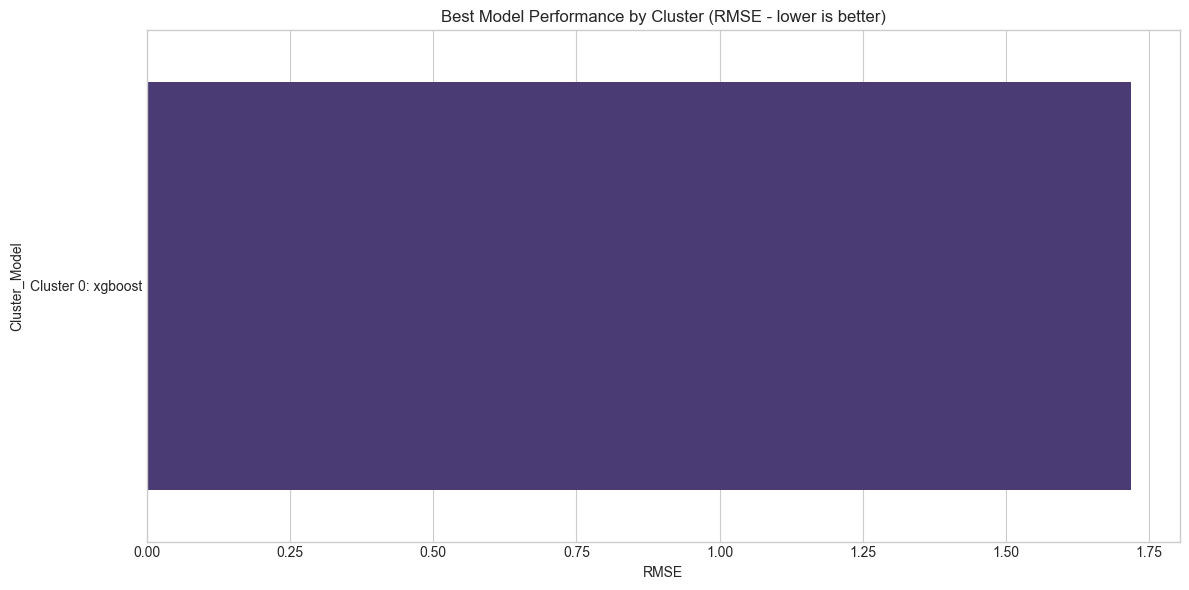

In [ ]:
# Create a summary of best models across clusters
summary_rows = []
for cluster_id in all_cluster_comparisons:
    best_model = all_cluster_comparisons[cluster_id].iloc[0]
    summary_rows.append({
        'Cluster': cluster_id,
        'Best Model': best_model['Model'],
        'RMSE': best_model['RMSE'],
    })

cluster_summary = pd.DataFrame(summary_rows).sort_values('RMSE')

print("\nBest Models by Cluster:")
print(cluster_summary)

# Plot cluster performance comparison
plt.figure(figsize=(12, 6))
cluster_summary_plot = cluster_summary.copy()
cluster_summary_plot['Cluster_Model'] = cluster_summary_plot.apply(
    lambda x: f"Cluster {x['Cluster']}: {x['Best Model']}", axis=1
)
sns.barplot(x='RMSE', y='Cluster_Model', data=cluster_summary_plot)
plt.title('Best Model Performance by Cluster (RMSE - lower is better)')
plt.tight_layout()
plt.show()

In [ ]:
all_cluster_results

{0: {'decision_tree': {'best_params': {'preprocessing': ColumnTransformer(remainder='passthrough',
                      transformers=[('num', StandardScaler(),
                                     ['temperature_2m', 'rain', 'snowfall',
                                      'cloud_cover', 'wind_gusts_10m',
                                      'wind_speed_10m', 'num_bikes_available',
                                      'latitude', 'longitude', 'dayofweek',
                                      'dayofyear']),
                                    ('cat',
                                     OneHotEncoder(handle_unknown='ignore',
                                                   sparse_output=False),
                                     ['isHoliday', 'has_kiosk', 'weather_cluster',
                                      'workhours', 'commute', 'free', 'night']),
                                    ('time',
                                     OneHotEncoder(handle_unknown='ignore',
      